# Counterfeit detection

The task in this assignment is to detect the  counterfeit banknotes. The data set is based on [banknote authentication Data Set ](https://archive.ics.uci.edu/ml/datasets/banknote+authentication#) from UCI Machine Learning repository. The first three columns denote different parameters obtained from the photographs of the banknotes and last colum provides the label. Frankly as the dataset does not have any description I don't know  which labels corresponds to real and which to counterfeited banknotes. let's assume that label one (positive) denotes the clounterfeits. The set  "banknote_authentication.csv" can be found in the data  directory.

In [138]:
#All necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import sys
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from IPython.display import display
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate
print("DONE")

DONE


In [139]:

sys.path.append("../../")

from mchlearn.plotting import roc_plot, add_roc_curve
from mchlearn.plotting import confidence_ellipse, decision_plot

data = pd.read_csv('data/banknote_authentication.csv')
data = data.dropna(how='any')

data.head()

,a1,a2,a3,counterfeit
0,12.3784,0.70403,-7.58360,0
1,8.1881,-3.13380,-2.52760,0
2,-10.8679,9.49260,-1.41160,1
3,-8.7903,7.97350,-0.45475,1
4,-5.5167,10.93900,-0.40820,1


## Problem 

### A.

Perform the Quadratic Discriminant Analysis on this set. Calculate the confusion matrix, AUC score and plot the ROC curve. 

-------------------------
----CONFUSION_MATRIX:----
-------------------------


,real label 1 (counterfeit),real label 0 (valid)
predicted label 1 (conterfeit),0.784483,0.163522
predicted label 0 (valid),0.215517,0.836478




-------------------------------
 FIT_QUALITY:_F1_PRECISION_AUC
-------------------------------


,tnr,fnr,fpr,tpr,precision,f1,auc
qda,0.836478,0.215517,0.163522,0.784483,0.814545,0.814545,0.886521




-------------------------------
-------------_ROC_-------------
-------------------------------


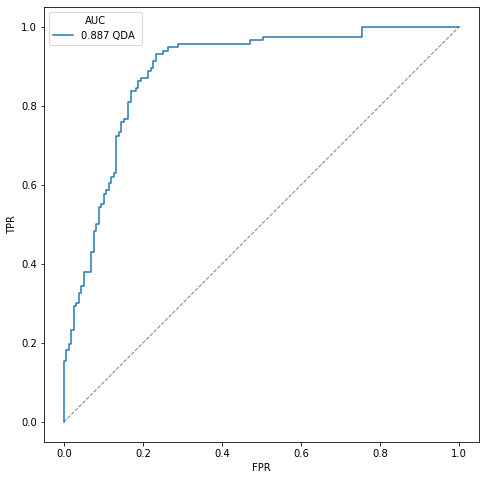

In [140]:
#Set aside 25% of data for testing!
seed = 77678
train_data, test_data = train_test_split(data, train_size=0.75, test_size=0.25, random_state = seed)

#Find train and test datasets.
train_X = train_data.iloc[:,:3]
train_Y = train_data.iloc[:,3]

test_X = test_data.iloc[:,:3]
test_Y = test_data.iloc[:,3]

#QDA classifier + training + prediction
cls=QuadraticDiscriminantAnalysis()
cls.fit(train_X,train_Y)
test_predicted = cls.predict(test_X)        
test_predicted_proba = cls.predict_proba(test_X)[:,1]


#confusion matrix
tnr, fpr, fnr, tpr = confusion_matrix(test_Y==1, test_predicted_proba>0.5, normalize='true').ravel()
disp = pd.DataFrame({"real label 1 (counterfeit)":  [tpr, fnr], "real label 0 (valid)":\
                             [fpr, tnr]}, index=["predicted label 1 (conterfeit)","predicted label 0 (valid)"])
print("-------------------------")
print("----CONFUSION_MATRIX:----")
print("-------------------------")
display(disp)

#precision + f1_score + auc
precision = precision_score(test_Y, test_predicted, pos_label=1, average='micro')
f1 = f1_score(test_Y, test_predicted, pos_label=1, average='micro')

auc = roc_auc_score(test_Y, test_predicted_proba)

dataframe=pd.DataFrame({'tnr':[tnr],
                            'fnr':[fnr],
                            'fpr':[fpr],
                            'tpr':[tpr],
                            'precision' : [precision],
                            'f1' :[f1],
                            'auc' :[auc]
                            }, index=["qda"])
    
print("\n\n-------------------------------")
print(" FIT_QUALITY:_F1_PRECISION_AUC")
print("-------------------------------")
display(dataframe)



print("\n\n-------------------------------")
print("-------------_ROC_-------------")
print("-------------------------------")
from mchlearn.plotting import roc_plot, add_roc_curve
fig, ax = roc_plot()
add_roc_curve(test_Y, test_predicted_proba, 'QDA', ax);
ax.legend(title='AUC');
qda_proba=test_predicted_proba

plt.show()

### B.

Perform Gaussian Mixture Discriminant Analysis on this set as described in the `gaussian_mixture_model_EM_algorithm` notebook. Use two components for positives and two components for negatives. Calculate the confusion matrix, AUC score and plot the ROC curve. 

In [141]:
def make_pdf(cmp):
    """
    Takes a GaussianMixture object and returns corresponding
    probability distribution function
    """
    n_cmp = cmp.n_components
    dists = [st.multivariate_normal(cmp.means_[i], cmp.covariances_[i]) for i in range(n_cmp)]
    def pdf(x):
        p = 0.0
        for i in range(n_cmp):
            p+= cmp.weights_[i]*dists[i].pdf(x)
        return p
    
    return pdf
    
    
def make_predict_proba(cmp0, cmp1, pi0=0.5, pi1=.5):
    """
    Takes two GaussianMixture object and corresponding priors and returns 
    pdf for conditional probability P(c=1|x)
    """
    pdf0 = make_pdf(cmp0)
    pdf1 = make_pdf(cmp1)
    def p(x):
        p0=pi0*pdf0(x)
        p1=pi1*pdf1(x)
        return p1/(p1+p0)    
        
    return p
print("DONE")

DONE


-------------------------
----CONFUSION_MATRIX:----
-------------------------


,real label 1 (counterfeit),real label 0 (valid)
predicted label 1 (conterfeit),0.784483,0.075472
predicted label 0 (valid),0.215517,0.924528




-------------------------------
 FIT_QUALITY:_AUC_
-------------------------------


,tnr,fnr,fpr,tpr,auc
GaussianMixture,0.924528,0.215517,0.075472,0.784483,0.946053




-------------------------------
-------------_ROC_-------------
-------------------------------


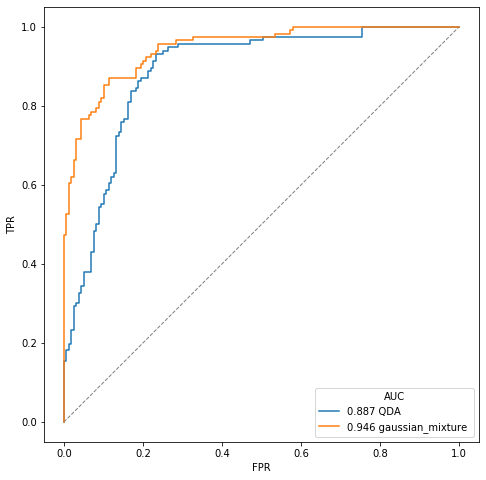

In [142]:
#Set aside 25% of data for testing!
data = pd.read_csv('data/banknote_authentication.csv')

seed = 77678
train_data, test_data = train_test_split(data, train_size=0.75, test_size=0.25, random_state = seed)

dane_X=data.iloc[:,:3]
dane_Y=data.iloc[:,3]

#Find train and test datasets.
train_X = train_data.iloc[:,:3]
train_Y = train_data.iloc[:,3]

test_X = test_data.iloc[:,:3]
test_Y = test_data.iloc[:,3]

hc0_cmp = GaussianMixture(n_components=2, max_iter=100, tol=0.0001) 
hc1_cmp = GaussianMixture(n_components=2, max_iter=100, tol=0.0001) 

hc0 = train_X[train_Y==0]
hc1 = train_X[train_Y==1]

hc0_cmp.fit(hc0)
hc1_cmp.fit(hc1)

mgd_predict_proba = make_predict_proba(hc0_cmp, hc1_cmp, 0.5, 0.5)
mgd_proba = mgd_predict_proba(test_X)

#confusion matrix
tnr, fpr, fnr, tpr = confusion_matrix(test_Y==1, mgd_proba>0.5, normalize='true').ravel()
disp = pd.DataFrame({"real label 1 (counterfeit)":  [tpr, fnr], "real label 0 (valid)":\
                             [fpr, tnr]}, index=["predicted label 1 (conterfeit)","predicted label 0 (valid)"])
print("-------------------------")
print("----CONFUSION_MATRIX:----")
print("-------------------------")
display(disp)

#precision + f1_score + auc
auc = roc_auc_score(test_Y, mgd_proba)



dataframe=pd.DataFrame({'tnr':[tnr],
                            'fnr':[fnr],
                            'fpr':[fpr],
                            'tpr':[tpr],
                            'auc' :[auc]
                            },index=["GaussianMixture"])

print("\n\n-------------------------------")
print(" FIT_QUALITY:_AUC_")
print("-------------------------------")
display(dataframe)

print("\n\n-------------------------------")
print("-------------_ROC_-------------")
print("-------------------------------")
fig, ax = roc_plot()
add_roc_curve(test_Y, qda_proba, 'QDA', ax);
add_roc_curve(test_Y, mgd_proba, 'gaussian_mixture', ax);
ax.legend(title='AUC');

### C.

Use k-fold cross validation to find the optimal number of gaussian components for each class. As before calculate the confusion matrix, AUC score and plot the ROC curve for the best classifier. 

__Hint__ use the `StratifiedKFold` function from scikit-learn library to generate folds. 

In [143]:
def make_pdf(cmp):
    """
    Takes a GaussianMixture object and returns corresponding
    probability distribution function
    """
    n_cmp = cmp.n_components
    dists = [st.multivariate_normal(cmp.means_[i], cmp.covariances_[i]) for i in range(n_cmp)]
    def pdf(x):
        p = 0.0
        for i in range(n_cmp):
            p+= cmp.weights_[i]*dists[i].pdf(x)
        return p
    
    return pdf
    
    
def make_predict_proba(cmp0, cmp1, pi0=0.5, pi1=.5):
    """
    Takes two GaussianMixture object and corresponding priors and returns 
    pdf for conditional probability P(c=1|x)
    """
    pdf0 = make_pdf(cmp0)
    pdf1 = make_pdf(cmp1)
    def p(x):
        p0=pi0*pdf0(x)
        p1=pi1*pdf1(x)
        return p1/(p1+p0)    
        
    return p
print("DONE")

DONE


In [144]:
from sklearn.metrics import accuracy_score

#Set aside 25% of data for testing!
dane_X= np.array(data.iloc[:,:3])
dane_y= np.array(data.iloc[:,3])

num_components = [1,2,3,4,5,6,7,8,9,10]

model0 = np.array([GaussianMixture(n_components=t, max_iter=300, tol=0.0001) for t in num_components])
model1 = np.array([GaussianMixture(n_components=t, max_iter=300, tol=0.0001) for t in num_components])

average_scores =  np.zeros((len(num_components), len(num_components)))

n_split=5

for k in num_components:
    for l in num_components:
        average_score = 0    
        cv = StratifiedKFold(n_splits=n_split, random_state=42, shuffle=True)
        for train_index, test_index in cv.split(dane_X, dane_y):

            X_train, X_test, y_train, y_test =\
            dane_X[train_index], dane_X[test_index], dane_y[train_index], dane_y[test_index]    

            X_train0 = X_train[np.where(y_train == 0)]
            X_train1 = X_train[np.where(y_train == 1)]

            model0[k-1].fit(X_train0)         
            model1[l-1].fit(X_train1)

            mgd_predict_proba_opt = make_predict_proba(model0[k-1], model1[l-1], 0.5, 0.5)
            mgd_proba_opt = mgd_predict_proba_opt(X_test)
            
                
            f1 = f1_score(y_test, mgd_proba_opt>0.5)

            average_score = average_score + (f1/n_split)
        average_scores[k-1][l-1] = average_score
        
print(np.matrix(average_scores))


print("DONE")

[[0.80850633 0.84048057 0.8431982  0.86838569 0.87729303 0.87681053
  0.88068006 0.8806372  0.89299435 0.89745607]
 [0.82735337 0.86607619 0.88893426 0.90002967 0.90837201 0.91912808
  0.91081936 0.91868753 0.90878162 0.90829054]
 [0.86766914 0.88906031 0.89380181 0.91323202 0.91398108 0.92358468
  0.91237909 0.90570121 0.90797374 0.9146649 ]
 [0.86669221 0.89915297 0.91799773 0.91628723 0.91802694 0.93272635
  0.9323636  0.92720851 0.91939421 0.92180444]
 [0.87616528 0.93066759 0.92022997 0.92441708 0.93141267 0.92723781
  0.92475635 0.9446711  0.93217328 0.9315848 ]
 [0.89901378 0.92734453 0.92191035 0.93261777 0.93763224 0.94019948
  0.94570062 0.94756368 0.94184823 0.94550357]
 [0.89299576 0.93376961 0.92458897 0.92652026 0.93776557 0.94434721
  0.94591871 0.94446261 0.93987493 0.94080063]
 [0.89744908 0.93263202 0.93004963 0.93503355 0.94134171 0.94039064
  0.95086766 0.93890406 0.94662319 0.9539877 ]
 [0.90142348 0.93006595 0.92533679 0.94067514 0.94329014 0.94757475
  0.95276219

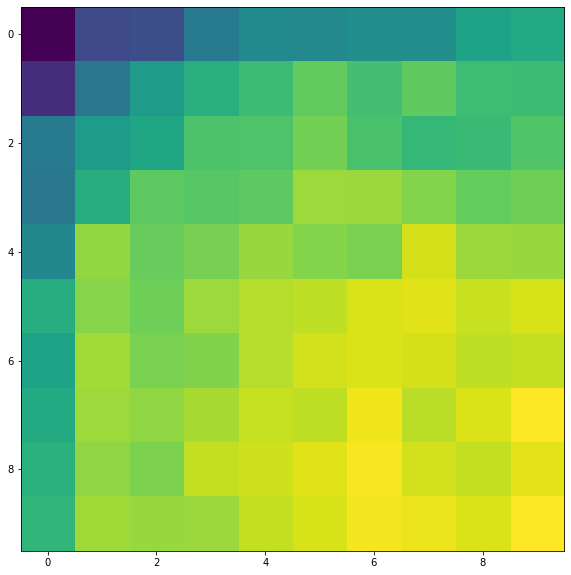

In [145]:
fig = plt.figure(figsize=(10,10))
ax.set_title('colorMap')
ax=fig.add_subplot(111)
plt.imshow(average_scores)
ax.set_aspect('equal')

In [146]:
max_score = np.where(average_scores == np.amax(average_scores))
print("coordinates of max score [counterfeit class, valid class]: ", [max_score[0][0], max_score[1][0]])

#calculate predictions for the optimal model
#(selected in validation process, the brightest cell on the heatmap above)
mgd_predict_proba_cross_val = make_predict_proba(model0[max_score[0][0]], model1[max_score[1][0]], 0.5, 0.5)
mgd_proba_cross_val = mgd_predict_proba_cross_val(test_X)

coordinates of max score [counterfeit class, valid class]:  [9, 9]


-------------------------
----CONFUSION_MATRIX:----
-------------------------


,real label 1 (counterfeit),real label 0 (valid)
predicted label 1 (conterfeit),0.922414,0.025157
predicted label 0 (valid),0.077586,0.974843




-------------------------------
 FIT_QUALITY:_AUC_
-------------------------------


,tnr,fnr,fpr,tpr,auc
gaussian_mixture_cross_validated,0.974843,0.077586,0.025157,0.922414,0.991759




-------------------------------
-------------_ROC_-------------
-------------------------------


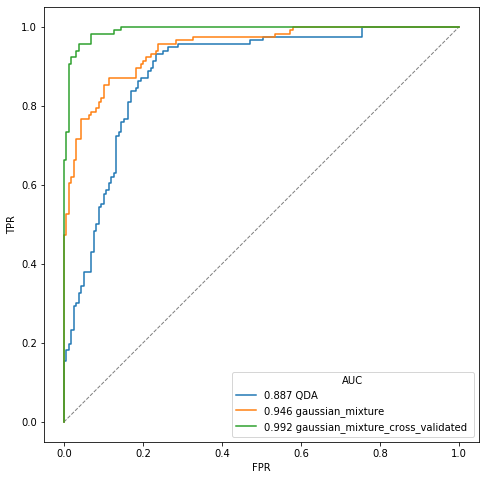

In [147]:
#confusion matrix
tnr, fpr, fnr, tpr = confusion_matrix(test_Y==1, mgd_proba_cross_val>=0.5, normalize='true').ravel()
disp_opt = pd.DataFrame({"real label 1 (counterfeit)":  [tpr, fnr], "real label 0 (valid)":\
                             [fpr, tnr]}, index=["predicted label 1 (conterfeit)","predicted label 0 (valid)"])
print("-------------------------")
print("----CONFUSION_MATRIX:----")
print("-------------------------")
display(disp_opt)

#AUC score
#precision + f1_score + auc
auc_opt = roc_auc_score(test_Y, mgd_proba_cross_val)
dataframe_opt=pd.DataFrame({'tnr':[tnr],
                            'fnr':[fnr],
                            'fpr':[fpr],
                            'tpr':[tpr],
                            'auc' :[auc_opt]
                            },index=["gaussian_mixture_cross_validated"])
print("\n\n-------------------------------")
print(" FIT_QUALITY:_AUC_")
print("-------------------------------")
display(dataframe_opt)

#ROC score
print("\n\n-------------------------------")
print("-------------_ROC_-------------")
print("-------------------------------")
fig, ax = roc_plot()
add_roc_curve(test_Y, qda_proba, 'QDA', ax);
add_roc_curve(test_Y, mgd_proba, 'gaussian_mixture', ax);
add_roc_curve(test_Y, mgd_proba_cross_val, 'gaussian_mixture_cross_validated', ax);
ax.legend(title='AUC');
plt.show()

## D.  

Assume that 1% of all the customers in your store presents a counterfeit 100PLN bill. If you accept the counterfeit bill you loose 100PLN. If you reject a valid bill,  you may loose the purchase, you estimate this loss as 15PLN on average. For each of the three classifiers find the threshold that minimises your losses and calculates the minimum loss for each classifier. Show the optimal classifiers points on the ROC curves.

# Error Cost from classification.ipynb: 
$price2⋅FPR⋅P(P)+price1⋅(1−TPR)⋅P(N)$

Problem parameters:  
$price2=15PLN$

$price1=100PLN$

$P(P)=0.99$

$P(N)=0.01$




-------------------------------
         QDA                    
-------------------------------
-----------MINIMUM LOSS-----------------
Minimal element of error_cost_qda (minimum loss)  0.845 . This element signifies threshold 0.975 , which can be found at index 2 .


-------------------------------
      COST_vs__THRESHOLD_QDA     
-------------------------------


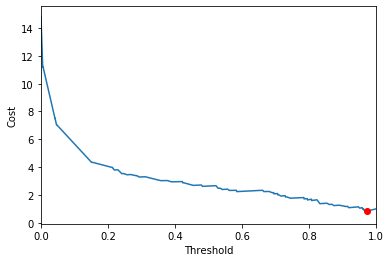



-------------------------------
-------------_ROC_QDA----------
-------------------------------


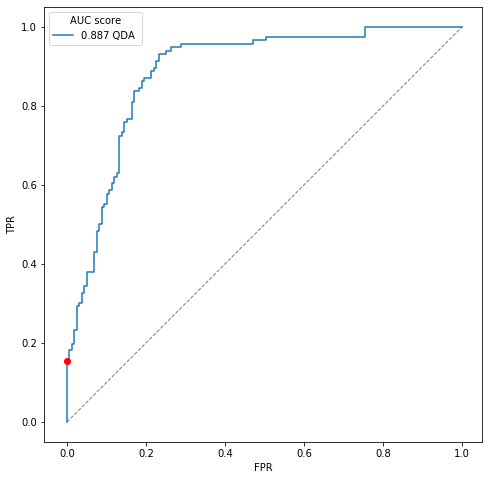

In [152]:
print("\n\n-------------------------------")
print("         QDA                    ")
print("-------------------------------")

# TPR, FPR, Threshold for  QDA
fpr_qda, tpr_qda, thd_qda = roc_curve(test_Y, test_predicted_proba)

error_costs_qda = (15*fpr_qda*0.99)+(100*(1-tpr_qda)*0.01)

#Find minimal error cost
min_error_cost_qda = np.argmin(error_costs_qda)
print("-----------MINIMUM LOSS-----------------")
print("Minimal element of error_cost_qda (minimum loss) ", np.round(error_costs_qda[min_error_cost_qda], decimals=3), ". This element signifies threshold",\
      np.round(thd_qda[min_error_cost_qda], decimals=3),", which can be found at index", min_error_cost_qda,".")

#Plot Cost vs Threshold function and find minimum (highlighted with red dot)
#ROC score
print("\n\n-------------------------------")
print("      COST_vs__THRESHOLD_QDA     ")
print("-------------------------------")
fig, ax = plt.subplots()
ax.set_ylabel("Cost")
ax.set_xlabel("Threshold")
ax.set_xlim(0,1)
ax.plot(thd_qda,error_costs_qda, zorder=1)
ax.scatter([thd_qda[min_error_cost_qda]], [error_costs_qda[min_error_cost_qda]], c='red', zorder=2)
plt.show()
#ROC score
print("\n\n-------------------------------")
print("-------------_ROC_QDA----------")
print("-------------------------------")
fig, ax = roc_plot()
add_roc_curve(test_Y, test_predicted_proba, 'QDA', ax)
ax.scatter([fpr_qda[min_error_cost_qda]], [tpr_qda[min_error_cost_qda]], c='red', zorder=5)
ax.legend(title = "AUC score");
plt.show()



-------------------------------
         MGD                    
-------------------------------
-----------MINIMUM LOSS-----------------
Minimal element of error_cost_qda (minumum loss) 0.526 . This element signifies threshold 0.968 , which can be found at index 2 .


-------------------------------
      COST_vs__THRESHOLD_MGD     
-------------------------------


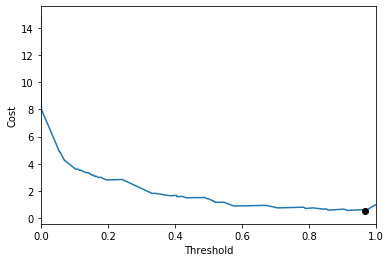



-------------------------------
-------------_ROC_MGD----------
-------------------------------


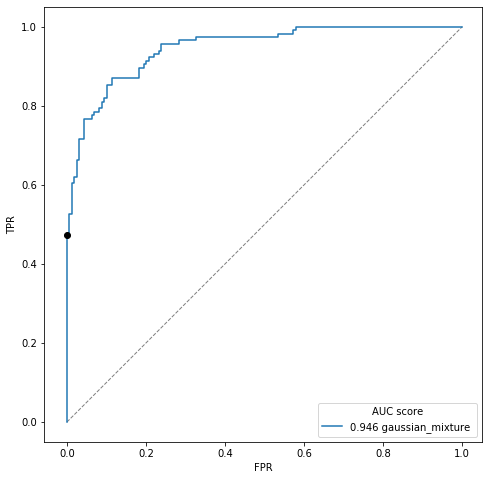

In [153]:
print("\n\n-------------------------------")
print("         MGD                    ")
print("-------------------------------")

# TPR, FPR, Threshold for MGD
fpr_mgd, tpr_mgd, thd_mgd = roc_curve(test_Y, mgd_proba)

error_costs_mgd = (15*fpr_mgd*0.99)+(100*(1-tpr_mgd)*0.01)

#Find minimal error cost
print("-----------MINIMUM LOSS-----------------")
print("Minimal element of error_cost_qda (minumum loss)", np.round(error_costs_mgd[min_error_cost_mgd], decimals=3), ". This element signifies threshold",\
      np.round(thd_mgd[min_error_cost_mgd], decimals=3),", which can be found at index", min_error_cost_mgd,".")
#Plot Cost vs Threshold function and find minimum (highlighted with red dot)
#ROC score
print("\n\n-------------------------------")
print("      COST_vs__THRESHOLD_MGD     ")
print("-------------------------------")
fig, ax = plt.subplots()
ax.set_ylabel("Cost")
ax.set_xlabel("Threshold")
ax.set_xlim(0,1)
ax.plot(thd_mgd, error_costs_mgd, zorder=1)
ax.scatter([thd_mgd[min_error_cost_mgd]], [error_costs_mgd[min_error_cost_mgd]], c='black', zorder=2)
plt.show()
#ROC score
print("\n\n-------------------------------")
print("-------------_ROC_MGD----------")
print("-------------------------------")
fig, ax = roc_plot()
add_roc_curve(test_Y, mgd_proba, 'gaussian_mixture', ax)
ax.scatter([fpr_mgd[min_error_cost_mgd]], [tpr_mgd[min_error_cost_mgd]], c='black', zorder=3)
ax.legend(title = "AUC score");
plt.show()



-------------------------------
         MGD_CV                    
-------------------------------
-------------MINIMUM LOSS-------------------
Minimal element of error_cost_qda (minimum loss) 0.282 . This element signifies threshold 0.96 , which can be found at index 7 .


-------------------------------
    COST_vs__THRESHOLD_MGD_CV_     
-------------------------------


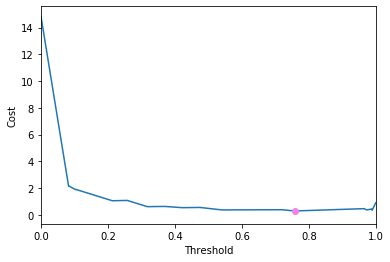



-------------------------------
           _ROC_MGD_CV_        
-------------------------------


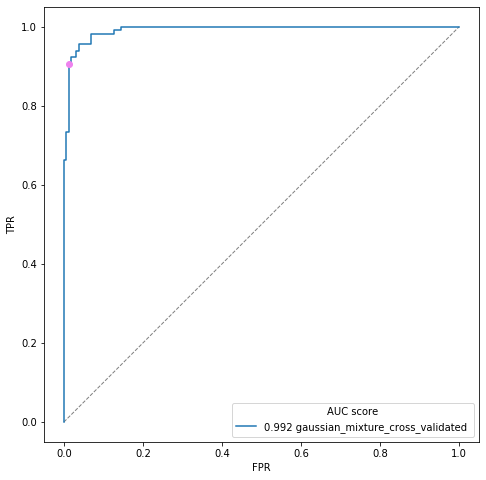

In [154]:
print("\n\n-------------------------------")
print("         MGD_CV                    ")
print("-------------------------------")

# TPR, FPR, Threshold for MGD_CV
fpr_mgd_cv, tpr_mgd_cv, thd_mgd_cv = roc_curve(test_Y, mgd_proba_cross_val)

error_costs_mgd_cv = (15*fpr_mgd_cv*0.99)+(100*(1-tpr_mgd_cv)*0.01)

#Find minimal error cost
min_error_cost_mgd_cv = np.argmin(error_costs_mgd_cv)
print("-------------MINIMUM LOSS-------------------")
print("Minimal element of error_cost_qda (minimum loss)", np.round(error_costs_mgd_cv[min_error_cost_mgd_cv], decimals=3), ". This element signifies threshold",\
      np.round(thd_qda[min_error_cost_mgd_cv], decimals=3),", which can be found at index", min_error_cost_mgd_cv,".")

#Plot Cost vs Threshold function and find minimum (highlighted with red dot)
#ROC score
print("\n\n-------------------------------")
print("    COST_vs__THRESHOLD_MGD_CV_     ")
print("-------------------------------")
fig, ax = plt.subplots()
ax.set_ylabel("Cost")
ax.set_xlabel("Threshold")
ax.set_xlim(0,1)
ax.plot(thd_mgd_cv, error_costs_mgd_cv, zorder=1)
ax.scatter([thd_mgd_cv[min_error_cost_mgd_cv]], [error_costs_mgd_cv[min_error_cost_mgd_cv]], c='violet', zorder=2)
plt.show()
#ROC score
print("\n\n-------------------------------")
print("           _ROC_MGD_CV_        ")
print("-------------------------------")
fig, ax = roc_plot()
add_roc_curve(test_Y, mgd_proba_cross_val, 'gaussian_mixture_cross_validated', ax)
ax.scatter([fpr_mgd_cv[min_error_cost_mgd_cv]], [tpr_mgd_cv[min_error_cost_mgd_cv]], c='violet', zorder=3)
ax.legend(title = "AUC score");
plt.show()




---------------------------------------------------------
                    SUMMARY                              
---------------------------------------------------------


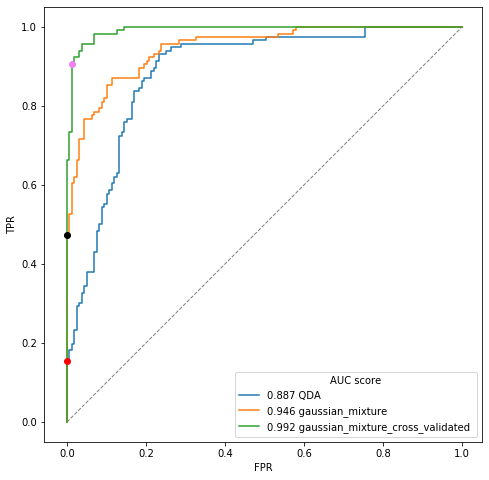

In [155]:
#---------------------------------------------SUMMARY----------------------------------------------------
print("\n\n")
print("---------------------------------------------------------")
print("                    SUMMARY                              ")
print("---------------------------------------------------------")
fig, ax = roc_plot()

add_roc_curve(test_Y, qda_proba, 'QDA', ax)
add_roc_curve(test_Y, mgd_proba, 'gaussian_mixture', ax)
add_roc_curve(test_Y, mgd_proba_cross_val, 'gaussian_mixture_cross_validated', ax)

ax.scatter([fpr_qda[min_error_cost_qda]], [tpr_qda[min_error_cost_qda]], c='red', zorder=3)
ax.scatter([fpr_mgd[min_error_cost_mgd]], [tpr_mgd[min_error_cost_mgd]], c='black', zorder=3)
ax.scatter([fpr_mgd_cv[min_error_cost_mgd_cv]], [tpr_mgd_cv[min_error_cost_mgd_cv]], c='violet', zorder=3)

ax.legend(title = "AUC score")
plt.show()